# Rural Villages Notebook
The purpose of this notebook is to create a model to predict the most rural villages connected by B2P bridges. Typically, when a bridge is built it is connecting 2-3 villages. One of those is often more connected to infrastructure, while the other is connected to that infrastructure by the bridge. For this reason, we are trying to answer which is the most rural village connected by a bridge so this data can be used in conjunction with other information to better assess the impact that bridges can have on communities.

We're going to approach this problem by measuring the distance from a village to the nearest road. We'll compare the measurements of each village a bridge connects and rank the villages in order. This ranking will be used to determine which village is the most rural. We have yet to determine which type of road we will use for the ranking. 

## Python Version
If you don't have python already installed on your machine, you will need to install it. We recommend using [Anaconda](https://www.anaconda.com/download/). Once you have Anacond installed, you should use this command to create a new environment with the correct version of python and all the necessary packages:
```conda create --name rural-villages python=3.10.6 jupyter pandas numpy matplotlib geopandas contextily shapely```

Once it's installed, you can activate the environment with this command:
```conda activate rural-villages```

## Import Dependencies

In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
import contextily as cx
from geopandas import GeoDataFrame as gdf

## Data Preparation
We'll be loading bridge data from B2P and village boundary data. In addition we'll bring in data from open street maps

In [2]:
input_data_path = "../../unsynced-data/rct-population/"
# Reading csv with bridges and village codes
rwanda_bridges = gpd.read_file(input_data_path + "B2P_Scaleup_Cascading_List_ARN edits.xlsx - Study Villages.csv")
# removing lat and lon columns with 'N/A' and '' values
rwanda_bridges = rwanda_bridges[rwanda_bridges.latitude != '#N/A']
rwanda_bridges = rwanda_bridges[rwanda_bridges.latitude != '']
#  convert latitude and longitude columns to float instead of string
rwanda_bridges['latitude'] = rwanda_bridges['latitude'].astype(float)
rwanda_bridges['longitude'] = rwanda_bridges['longitude'].astype(float)
# create geometry column
rwanda_bridges['geometry'] = gpd.points_from_xy(rwanda_bridges.longitude, rwanda_bridges.latitude)
# set a geographic CRS
rwanda_bridges = rwanda_bridges.set_crs(epsg=4326, inplace=True)
# preview first column to check out the data
rwanda_bridges.head(1)

,UID,District name,Site name,Site Code,Verified Village Code,Village name,Village Code,Most Affected Village,Most Affected Side,latitude,longitude,Comments,Contact,field_14,field_15,field_16,geometry
0,1,Burera,Cyabami Kwa Anamariya,1013233,44120303,Butunda,44120303,,,-1.60834,29.8911,,Joseph Baziruwiha 250781772373,,,,POINT (29.89110 -1.60834)


In [4]:
# read in village boundary data as geodataframe
village_boundaries = gpd.read_file(input_data_path + "Rwanda Village Boundaries.zip")
# using to_crs instead of set_crs because there is already a crs set
village_boundaries = village_boundaries.to_crs(epsg=4326)
# not assigning centroids because we can use the polygon type data to determine distance to roads
# village_boundaries['centroid'] = village_boundaries.centroid
# preview first column to check out the data
village_boundaries.head(1)

,District,Village_ID,Cell_ID,Sector_ID,Distr_ID,Prov_ID,Name,Cell,Sector,Province,geometry
0,Nyarugenge,11010102,110101,1101,11,1,Gihanga,Akabahizi,Gitega,Kigali Town/Umujyi wa Kigali,"POLYGON Z ((30.05217 -1.94732 0.00000, 30.0522..."


<Axes: >

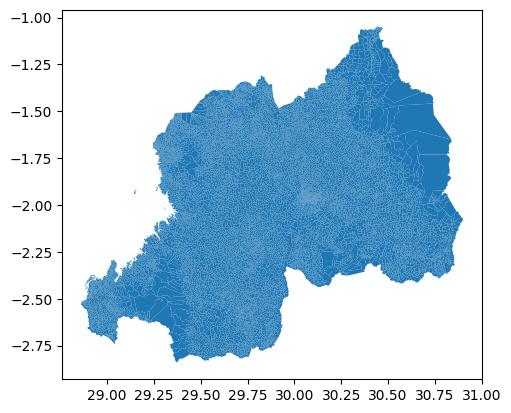

In [5]:
# view on map to double check it looks right
village_boundaries.plot()

We're pulling road data from open street maps. We're grabbing data for the country of Rwanda for each road type. Read more about the "Highway" data type [here](https://wiki.openstreetmap.org/wiki/Key:highway). We used [Overpass Turbo](https://overpass-turbo.eu/) to download the data. Note, there are no roads classified as "motorways" in Rwanda so we are not using this data data type.

In [9]:
village_boundaries

,District,Village_ID,Cell_ID,Sector_ID,Distr_ID,Prov_ID,Name,Cell,Sector,Province,geometry
0,Nyarugenge,11010102,110101,1101,11,1,Gihanga,Akabahizi,Gitega,Kigali Town/Umujyi wa Kigali,"POLYGON Z ((30.05217 -1.94732 0.00000, 30.0522..."
1,Nyarugenge,11010103,110101,1101,11,1,Iterambere,Akabahizi,Gitega,Kigali Town/Umujyi wa Kigali,"POLYGON Z ((30.05147 -1.94394 0.00000, 30.0516..."
2,Nyarugenge,11010104,110101,1101,11,1,Izuba,Akabahizi,Gitega,Kigali Town/Umujyi wa Kigali,"POLYGON Z ((30.05114 -1.94415 0.00000, 30.0513..."
3,Nyarugenge,11010105,110101,1101,11,1,Nyaburanga,Akabahizi,Gitega,Kigali Town/Umujyi wa Kigali,"POLYGON Z ((30.05468 -1.94683 0.00000, 30.0545..."
4,Nyarugenge,11010106,110101,1101,11,1,Nyenyeri,Akabahizi,Gitega,Kigali Town/Umujyi wa Kigali,"POLYGON Z ((30.05195 -1.94681 0.00000, 30.0520..."
...,...,...,...,...,...,...,...,...,...,...,...
14810,Bugesera,57150501,571505,5715,57,5,Gaseke,Rutare,Shyara,East/Iburasirazuba,"POLYGON Z ((30.00423 -2.26651 0.00000, 30.0046..."
14811,Bugesera,57150502,571505,5715,57,5,Kamweru,Rutare,Shyara,East/Iburasirazuba,"POLYGON Z ((29.99916 -2.27978 0.00000, 29.9992..."
14812,Bugesera,57150503,571505,5715,57,5,Ruhanga,Rutare,Shyara,East/Iburasirazuba,"POLYGON Z ((29.98839 -2.27714 0.00000, 29.9890..."
14813,Bugesera,57150504,571505,5715,57,5,Rutare,Rutare,Shyara,East/Iburasirazuba,"POLYGON Z ((30.00550 -2.27251 0.00000, 30.0057..."


In [8]:
# read in all road data
trunk = gpd.read_file(input_data_path + "rwanda_highway-trunk.geojson")
primary = gpd.read_file(input_data_path + "rwanda_highway-primary.geojson")
secondary = gpd.read_file(input_data_path + "rwanda_highway-secondary.geojson")
tertiary = gpd.read_file(input_data_path + "rwanda_highway-tertiary.geojson")
unclassified = gpd.read_file(input_data_path + "rwanda_highway-unclassified.geojson")
residential = gpd.read_file(input_data_path + "rwanda_highway-residential.geojson")

# create list of road data dataframes to use them all later
road_data = [trunk, primary, secondary, tertiary, unclassified, residential]

# verifying columns in road data
trunk.head(1)


,id,@id,AUTO_ID,alt_name,alt_name:fr,bicycle,bridge,covered,cutting,driving_side,...,origen,ref,ref:fr,shoulder,sidewalk,sidewalk:right,source,source:shape,surface,geometry
0,way/25796130,way/25796130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NR1,NaN,NaN,NaN,yes,survey,NaN,paved,"LINESTRING (30.06216 -1.94368, 30.06216 -1.943..."


In [19]:
# set projection to epsg:4326 for all dataframes
for d in road_data:
    d = d.to_crs(epsg=4326)

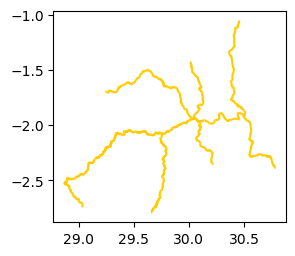

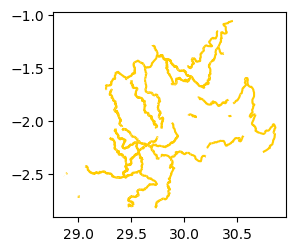

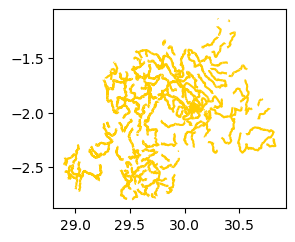

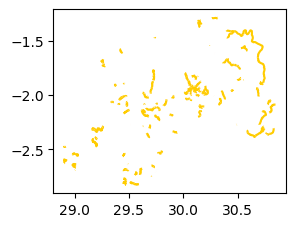

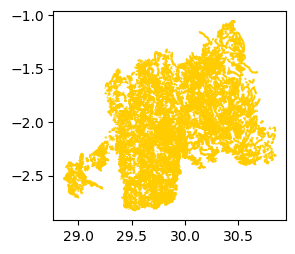

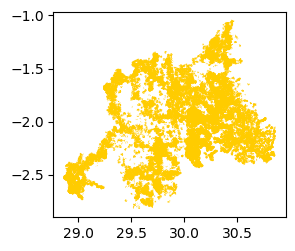

In [20]:
# plot each road type to double check data integrity
for r in road_data:
    r.plot(color="#ffcc00", figsize=(3,3))

## Data Analysis
The permise of what we're doing below is taking the distance from each village to each road type. This value will be used to rank the villages and then we will add this ranking to the bridge data with the village polygons. This should serve as one dataset we can use to create a map or do further analysis on.

### Measuring Distance

In [23]:
# create a new column in village_boundaries with distance from village boundary to each road type
village_boundaries["trunk_distance"] = village_boundaries["geometry"].distance(trunk.unary_union)
village_boundaries["primary_distance"] = village_boundaries["geometry"].distance(primary.unary_union)
village_boundaries["secondary_distance"] = village_boundaries["geometry"].distance(secondary.unary_union)
village_boundaries["tertiary_distance"] = village_boundaries["geometry"].distance(tertiary.unary_union)
village_boundaries["unclassified_distance"] = village_boundaries["geometry"].distance(unclassified.unary_union)
village_boundaries["residential_distance"] = village_boundaries["geometry"].distance(residential.unary_union)
# preview data to check things look right
village_boundaries

# errors will show below that there is not a geographic CRS. This is not correct as we have already set a CRS. Not sure why the errors are showing.  

/var/folders/3v/8xxt4zw96bn2l6qwb8w7_5r40000gn/T/ipykernel_20768/884687873.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  village_boundaries["trunk_distance"] = village_boundaries["geometry"].distance(trunk.unary_union)
/var/folders/3v/8xxt4zw96bn2l6qwb8w7_5r40000gn/T/ipykernel_20768/884687873.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  village_boundaries["primary_distance"] = village_boundaries["geometry"].distance(primary.unary_union)
/var/folders/3v/8xxt4zw96bn2l6qwb8w7_5r40000gn/T/ipykernel_20768/884687873.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

,District,Village_ID,Cell_ID,Sector_ID,Distr_ID,Prov_ID,Name,Cell,Sector,Province,geometry,trunk_distance,primary_distance,secondary_distance,tertiary_distance,unclassified_distance,residential_distance
0,Nyarugenge,11010102,110101,1101,11,1,Gihanga,Akabahizi,Gitega,Kigali Town/Umujyi wa Kigali,"POLYGON Z ((30.05217 -1.94732 0.00000, 30.0522...",0.007592,0.009232,0.001513,0.000000,0.000010,0.000000
1,Nyarugenge,11010103,110101,1101,11,1,Iterambere,Akabahizi,Gitega,Kigali Town/Umujyi wa Kigali,"POLYGON Z ((30.05147 -1.94394 0.00000, 30.0516...",0.003779,0.005475,0.000000,0.000000,0.001976,0.000000
2,Nyarugenge,11010104,110101,1101,11,1,Izuba,Akabahizi,Gitega,Kigali Town/Umujyi wa Kigali,"POLYGON Z ((30.05114 -1.94415 0.00000, 30.0513...",0.004270,0.005820,0.000262,0.000000,0.002912,0.000703
3,Nyarugenge,11010105,110101,1101,11,1,Nyaburanga,Akabahizi,Gitega,Kigali Town/Umujyi wa Kigali,"POLYGON Z ((30.05468 -1.94683 0.00000, 30.0545...",0.006474,0.009124,0.000000,0.000000,0.001711,0.000000
4,Nyarugenge,11010106,110101,1101,11,1,Nyenyeri,Akabahizi,Gitega,Kigali Town/Umujyi wa Kigali,"POLYGON Z ((30.05195 -1.94681 0.00000, 30.0520...",0.006643,0.008257,0.001220,0.000000,0.000189,0.000382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14810,Bugesera,57150501,571505,5715,57,5,Gaseke,Rutare,Shyara,East/Iburasirazuba,"POLYGON Z ((30.00423 -2.26651 0.00000, 30.0046...",0.127492,0.025057,0.000016,0.089794,0.000000,0.010028
14811,Bugesera,57150502,571505,5715,57,5,Kamweru,Rutare,Shyara,East/Iburasirazuba,"POLYGON Z ((29.99916 -2.27978 0.00000, 29.9992...",0.134028,0.010968,0.001110,0.074035,0.000000,0.004484
14812,Bugesera,57150503,571505,5715,57,5,Ruhanga,Rutare,Shyara,East/Iburasirazuba,"POLYGON Z ((29.98839 -2.27714 0.00000, 29.9890...",0.145958,0.007371,0.014259,0.070870,0.000000,0.020798
14813,Bugesera,57150504,571505,5715,57,5,Rutare,Rutare,Shyara,East/Iburasirazuba,"POLYGON Z ((30.00550 -2.27251 0.00000, 30.0057...",0.130321,0.017630,0.000000,0.088460,0.000000,0.006422


below we're plotting a distribution of different road types. This is a gut check to see if we've done the distance measurement correctly. there should likely be many values close to zero that exponentially tail off headed to the right. Furthmore, more rural road types should have a higher proportion of values at zero as they cross the boundaries of village polygons more often.


<AxesSubplot: ylabel='Frequency'>

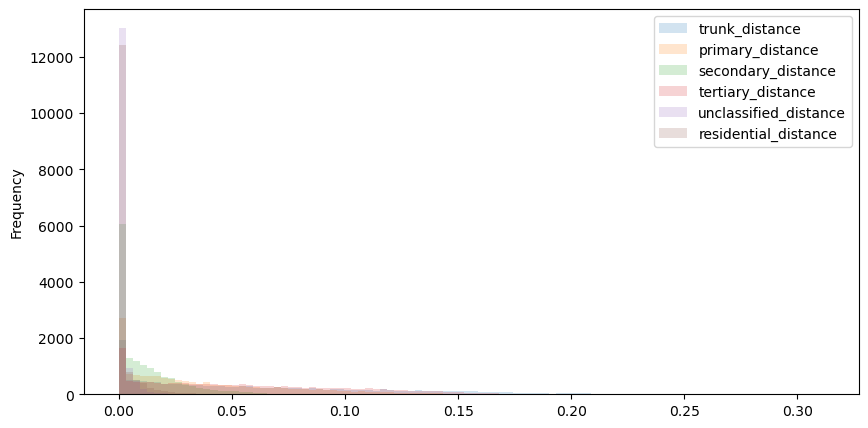

In [24]:
village_boundaries[["trunk_distance", "primary_distance", "secondary_distance", "tertiary_distance", "unclassified_distance", "residential_distance"]].plot(alpha=0.2, kind="hist", bins=100 , figsize=(10,5))

In [25]:
# add a column to rwanda_bridges with road distance that where village_ID and Verified village Code match this is our data join adding what we've done previously to the bridge data.
rwanda_bridges["trunk_distance"] = rwanda_bridges["Verified Village Code"].map(village_boundaries.set_index("Village_ID")["trunk_distance"])
rwanda_bridges["primary_distance"] = rwanda_bridges["Verified Village Code"].map(village_boundaries.set_index("Village_ID")["primary_distance"])
rwanda_bridges["secondary_distance"] = rwanda_bridges["Verified Village Code"].map(village_boundaries.set_index("Village_ID")["secondary_distance"])
rwanda_bridges["tertiary_distance"] = rwanda_bridges["Verified Village Code"].map(village_boundaries.set_index("Village_ID")["tertiary_distance"])
rwanda_bridges["unclassified_distance"] = rwanda_bridges["Verified Village Code"].map(village_boundaries.set_index("Village_ID")["unclassified_distance"])
rwanda_bridges["residential_distance"] = rwanda_bridges["Verified Village Code"].map(village_boundaries.set_index("Village_ID")["residential_distance"])


In [88]:
# sorting rwanda_bridges sort by verified village code to double check that things seem to have worked
rwanda_bridges = rwanda_bridges.sort_values(by=['Verified Village Code'])
# preview data to check things look right
rwanda_bridges

,UID,District name,Site name,Site Code,Verified Village Code,Village name,Village Code,Most Affected Village,Most Affected Side,latitude,...,field_14,field_15,field_16,geometry,trunk_distance,primary_distance,secondary_distance,tertiary_distance,unclassified_distance,residential_distance
362,364,Nyarugenge,Nyarusange,1014269,11020302,Ngendo,11020302,Yes,No,-1.894583,...,,,,POINT (29.99660 -1.89458),0.000000,0.051125,0.007245,0.047444,0.000000,0.002445
348,350,Nyarugenge,Karukina,1014268,11050102,Kankuba,11050102,Yes,Yes,-2.018610,...,,,,POINT (30.00850 -2.01861),0.060832,0.081361,0.000000,0.000000,0.000000,0.000000
350,352,Nyarugenge,Karukina,1014268,11050103,Karukira,#N/A,Yes,No,-2.018610,...,,,,POINT (30.00850 -2.01861),0.048452,0.077773,0.000000,0.000503,0.000000,0.000000
349,351,Nyarugenge,Karukina,1014268,11050202,Kankurimba,11050202,Yes,Yes,-2.018610,...,,,,POINT (30.00850 -2.01861),0.054425,0.091987,0.000000,0.012760,0.000000,0.011490
358,360,Nyarugenge,Nyarubuye,1014267,11050205,Murondo,11050205,Yes,Yes,-2.049250,...,,,,POINT (29.98573 -2.04925),0.051854,0.082864,0.000000,0.018961,0.000000,0.011729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,51,Gicumbi,Karama Muhengeri,1010917,45120408,Nyarubande,45120408,No,Yes,-1.671847,...,,,,POINT (30.05734 -1.67185),0.011726,0.034483,0.000000,0.121724,0.000000,0.000000
52,54,Gicumbi,Nyagakizi,1009714,53110405,Mubirembo,53110405,Yes,No,-1.533333,...,,,,POINT (30.17361 -1.53333),0.083747,0.059769,0.001311,0.063613,0.000000,0.000000
351,353,Nyarugenge,Mpanga,1014265,57090302,Kagoma Ii,57090302,Yes,No,-2.063800,...,,,,POINT (30.02790 -2.06380),0.046455,0.100176,0.000000,0.024921,0.000014,0.000000
356,358,Nyarugenge,Nyabirondo,1014264,57090303,Kiganwa,57090303,Yes,No,-2.054340,...,,,,POINT (30.04781 -2.05434),0.028709,0.100558,0.000318,0.010300,0.001140,0.000000


In [26]:
# adding village polygons to data set
rwanda_bridges["village_geometry"] = rwanda_bridges["Verified Village Code"].map(village_boundaries.set_index("Village_ID")["geometry"])
# previewing data to check things look right
rwanda_bridges

,UID,District name,Site name,Site Code,Verified Village Code,Village name,Village Code,Most Affected Village,Most Affected Side,latitude,...,field_15,field_16,geometry,trunk_distance,primary_distance,secondary_distance,tertiary_distance,unclassified_distance,residential_distance,village_geometry
0,1,Burera,Cyabami Kwa Anamariya,1013233,44120303,Butunda,44120303,,,-1.60834,...,,,POINT (29.89110 -1.60834),0.050759,0.007020,0.008350,0.079850,0.000000,0.001209,"POLYGON Z ((29.90167 -1.60157 0.00000, 29.9018..."
1,2,Burera,Nyabizi ya 1,1013496,44100402,Gitenge,44100402,Yes,No,-1.33001,...,,,POINT (29.82555 -1.33001),0.202829,0.035588,0.000000,0.139621,0.000000,0.000862,"POLYGON Z ((29.81795 -1.34070 0.00000, 29.8179..."
2,3,Burera,Nyabizi ya 1,1013496,44100406,Nyabizi I,44100406,Yes,Yes,-1.33001,...,,,POINT (29.82555 -1.33001),0.204921,0.048757,0.004400,0.152792,0.000000,0.007393,"POLYGON Z ((29.82186 -1.31770 0.00000, 29.8219..."
3,4,Burera,Nyabizi ya 1,1013496,44100407,Nyabizi II,44100407,Yes,Yes,-1.33001,...,,,POINT (29.82555 -1.33001),0.193434,0.054271,0.009066,0.158064,0.000000,0.009942,"POLYGON Z ((29.83845 -1.32197 0.00000, 29.8387..."
4,5,Burera,Nyabizi ya 1,1013496,44100409,Rubayu,44100409,No,Yes,-1.33001,...,,,POINT (29.82555 -1.33001),0.211094,0.038980,0.001334,0.142286,0.001060,0.005308,"MULTIPOLYGON Z (((29.81795 -1.34070 0.00000, 2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,462,Rutsiro,Gakoyi,1013654,32090204,Kivumu,32050105,Yes,Yes,-1.85437,...,,,POINT (29.28597 -1.85437),0.151775,0.053523,0.000000,0.088256,0.000000,0.000000,"POLYGON Z ((29.29159 -1.85486 0.00000, 29.2915..."
461,463,Rutsiro,Gakoyi,1013654,32090205,Maziba,32090205,Yes,No,-1.85437,...,,,POINT (29.28597 -1.85437),0.143222,0.050334,0.000000,0.090744,0.003103,0.000000,"MULTIPOLYGON Z (((29.28463 -1.85635 0.00000, 2..."
462,464,Rutsiro,Rusayo,1012004,32130401,Gisozi,32130401,No,Yes,-1.96222,...,,,POINT (29.46139 -1.96222),0.078016,0.103030,0.015277,0.046748,0.000000,0.022524,"POLYGON Z ((29.52418 -1.94932 0.00000, 29.5242..."
463,465,Rutsiro,Rusayo,1012004,32130405,Nyamibombwe,32130405,No,No,-1.96222,...,,,POINT (29.46139 -1.96222),0.079669,0.094487,0.007839,0.044909,0.000000,0.009422,"POLYGON Z ((29.49725 -1.96577 0.00000, 29.4956..."


In [27]:
# creating a back up of our dataframe in case we mess something up down the line.
rwanda_bridges_proof = rwanda_bridges

### Ranking Villages
creating a rural ranking for each road type. This will take entries from rwanda_bridges that match site code and rank them by their road type distance (e.g. trunk_distance1, primary_distance, etc.)
closest = 1.0, furthest = 4.0 this is ranked so not all bridges have 4 villages attached to them

In [30]:

# create a new column in rwanda_bridges with rural ranking for each road type
rwanda_bridges["trunk_rank"] = rwanda_bridges.groupby("Site Code")["trunk_distance"].rank(method="dense", ascending=True)
rwanda_bridges["primary_rank"] = rwanda_bridges.groupby("Site Code")["primary_distance"].rank(method="dense", ascending=True)
rwanda_bridges["secondary_rank"] = rwanda_bridges.groupby("Site Code")["secondary_distance"].rank(method="dense", ascending=True)
rwanda_bridges["tertiary_rank"] = rwanda_bridges.groupby("Site Code")["tertiary_distance"].rank(method="dense", ascending=True)
rwanda_bridges["unclassified_rank"] = rwanda_bridges.groupby("Site Code")["unclassified_distance"].rank(method="dense", ascending=True)
rwanda_bridges["residential_rank"] = rwanda_bridges.groupby("Site Code")["residential_distance"].rank(method="dense", ascending=True)
# preview data to check things look right
rwanda_bridges


,UID,District name,Site name,Site Code,Verified Village Code,Village name,Village Code,Most Affected Village,Most Affected Side,latitude,...,tertiary_distance,unclassified_distance,residential_distance,village_geometry,trunk_rank,primary_rank,secondary_rank,tertiary_rank,unclassified_rank,residential_rank
0,1,Burera,Cyabami Kwa Anamariya,1013233,44120303,Butunda,44120303,,,-1.60834,...,0.079850,0.000000,0.001209,"POLYGON Z ((29.90167 -1.60157 0.00000, 29.9018...",1.0,1.0,1.0,1.0,1.0,1.0
1,2,Burera,Nyabizi ya 1,1013496,44100402,Gitenge,44100402,Yes,No,-1.33001,...,0.139621,0.000000,0.000862,"POLYGON Z ((29.81795 -1.34070 0.00000, 29.8179...",2.0,1.0,1.0,1.0,1.0,1.0
2,3,Burera,Nyabizi ya 1,1013496,44100406,Nyabizi I,44100406,Yes,Yes,-1.33001,...,0.152792,0.000000,0.007393,"POLYGON Z ((29.82186 -1.31770 0.00000, 29.8219...",3.0,3.0,3.0,3.0,1.0,3.0
3,4,Burera,Nyabizi ya 1,1013496,44100407,Nyabizi II,44100407,Yes,Yes,-1.33001,...,0.158064,0.000000,0.009942,"POLYGON Z ((29.83845 -1.32197 0.00000, 29.8387...",1.0,4.0,4.0,4.0,1.0,4.0
4,5,Burera,Nyabizi ya 1,1013496,44100409,Rubayu,44100409,No,Yes,-1.33001,...,0.142286,0.001060,0.005308,"MULTIPOLYGON Z (((29.81795 -1.34070 0.00000, 2...",4.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,462,Rutsiro,Gakoyi,1013654,32090204,Kivumu,32050105,Yes,Yes,-1.85437,...,0.088256,0.000000,0.000000,"POLYGON Z ((29.29159 -1.85486 0.00000, 29.2915...",2.0,3.0,1.0,2.0,1.0,1.0
461,463,Rutsiro,Gakoyi,1013654,32090205,Maziba,32090205,Yes,No,-1.85437,...,0.090744,0.003103,0.000000,"MULTIPOLYGON Z (((29.28463 -1.85635 0.00000, 2...",1.0,1.0,1.0,3.0,3.0,1.0
462,464,Rutsiro,Rusayo,1012004,32130401,Gisozi,32130401,No,Yes,-1.96222,...,0.046748,0.000000,0.022524,"POLYGON Z ((29.52418 -1.94932 0.00000, 29.5242...",1.0,3.0,3.0,2.0,1.0,3.0
463,465,Rutsiro,Rusayo,1012004,32130405,Nyamibombwe,32130405,No,No,-1.96222,...,0.044909,0.000000,0.009422,"POLYGON Z ((29.49725 -1.96577 0.00000, 29.4956...",2.0,2.0,1.0,1.0,1.0,1.0


### Exporting the Data

In [32]:
# export to a .csv file that will be used to make a map and other analysis
rwanda_bridges.to_csv("./data products/rwanda_bridges_ruralrank.csv")

## Conclusion
The data in the Data Products folder is the output of this notebook. It is a csv file that contains the bridge data with the rural ranking added. This data can be used to create a map or do further analysis. A preliminary map of the dta can be found below or at [this link](https://studio.unfolded.ai/public/af49d338-2992-4ccf-a612-f93755822673). It still needs to be decided whether this is a good estimation of which villages are the most rural. Furthermore, it needs to be determined which road type should be used in this ranking. Right now, our best guess is that unclassified or residential roads are the best indicator.

<iframe width="100%" height="500px" src="https://studio.unfolded.ai/public/af49d338-2992-4ccf-a612-f93755822673/embed" frameborder="0" allowfullscreen></iframe>